In [1]:
import random
import numpy as np
import matplotlib
import time
from numba import jit
import multiprocessing as mp
from matplotlib import pyplot as plt

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Demand

In [2]:
@jit(nopython=True)
def demand(p1, p2):
    if p1 < p2:
        d = 1 - p1
    elif p1 == p2:
        d = 0.5 * (1 - p1)
    else:
        d = 0
    return d

# Profit

In [3]:
@jit(nopython=True)
def profit(p1, p2):
    return (p1 * demand(p1, p2))

In [4]:
P = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]) # price array

# Epsilon greedy

In [5]:
@jit(nopython=True)
def epsilon_greedy(Qtable, epsilon, uniform, state: int, price_grid: np.ndarray) -> int: 
    N = len(price_grid)
    assert Qtable.shape[0] == N, "Qtable must have the same number of rows as there are prices in the grid"
    assert Qtable.shape[1] == N, "Qtable must have the same number of columns as there are prices in the grid"
    assert state < N, "state must be a valid index in the price grid"
    assert state >= 0, "state must be a valid index in the price grid"

    # Draw action 
    if uniform < epsilon:
        price_index = np.random.choice(N)
    else:
        price_index = np.argmax(Qtable[:, state])
    return price_index

# Players:

### Q-learner

In [17]:
@jit(nopython=True)
def update_Qtable(Qtable, price_grid, price_index_i, state, price_index_j_next_period, delta, alpha, t):
    if t % 2 != 0:
        print("Update - start")
        print("T = ", t)
        #current period
        print("price_index_i:", price_index_i)
        print("price_index_j:", state)
        print("price_index_j_next_period:", price_index_j_next_period)
        print("Qtable - start:", Qtable)
        decision = price_grid[price_index_i]
        print("decision:", decision)
        state_i_responds_to = price_grid[state]
        print("state_i_responds_to:", state_i_responds_to)
        profit_i_current_period = profit(decision, state_i_responds_to)
        print("profit_i_current_period:", profit_i_current_period)
    
        # next period
        price_j_next_period = price_grid[price_index_j_next_period]
        print("price_j_next_period:", price_j_next_period)
        price_i_next_period = price_grid[price_index_i] # unchanged price, it's not i's turn 
        print("price_i_next_period:",price_i_next_period)
        profit_i_next_period = profit(price_i_next_period, price_j_next_period)
        print("profit_i_next_period:", profit_i_next_period)

        max_Q = np.max(Qtable[:, price_index_j_next_period])
        continuation_value = max_Q 

        new_estimate = profit_i_current_period + delta * profit_i_next_period + delta**2 * continuation_value

        # Update
        prev_estimate = Qtable[price_index_i, state]

        # Update Q-table for player i
        Qtable[price_index_i, state] = (1 - alpha) * prev_estimate + alpha * new_estimate
        print("Qtable:", Qtable)
        print("Update - slut")
    else: 
        print("Update - start")
        print("T = ", t)
        # current period 
        print("price_index_i:", price_index_i)
        print("price_index_j:", state)
        print("price_index_j_next_period:", price_index_j_next_period)
        print("Qtable - start:", Qtable)
        decision = price_grid[price_index_i]
        print("decision:", decision)
        state_i_responds_to = price_grid[state]
        print("state_i_responds_to:", state_i_responds_to)
        profit_i_current_period = profit(decision, state_i_responds_to)
        print("profit_i_current_period:", profit_i_current_period)
    
        # next period
        price_j_next_period = price_grid[price_index_j_next_period]
        print("price_j_next_period:", price_j_next_period)
        price_i_next_period = price_grid[price_index_i] # unchanged price, it's not i's turn 
        print("price_i_next_period:",price_i_next_period)
        profit_i_next_period = profit(price_i_next_period, price_j_next_period)
        print("profit_i_next_period:", profit_i_next_period)

        max_Q = np.max(Qtable[:, price_index_j_next_period])
        continuation_value = max_Q 

        new_estimate = profit_i_current_period + delta * profit_i_next_period + delta**2 * continuation_value

        # Update
        prev_estimate = Qtable[price_index_i, state]

        # Update Q-table for player i
        Qtable[price_index_i, state] = (1 - alpha) * prev_estimate + alpha * new_estimate
        print("Qtable:", Qtable)
        print("Update - slut")

### Fictitious Player

In [30]:
def Fictitious_Player():
    

IndentationError: expected an indented block (1557528782.py, line 2)

# Game

In [18]:
@jit(nopython=True)
def game(price_grid, periods, delta, alpha, theta):
     # Initialize prices and Q-tables
    price_index_i = np.random.choice(len(price_grid)) 
    price_index_j = np.random.choice(len(price_grid)) 
    price_index_j_next_period = np.random.choice(len(price_grid))
    temp_index = np.random.choice(len(price_grid))

    Qtable_1 = np.zeros((len(price_grid), len(price_grid)))
    Qtable_2 = np.zeros((len(price_grid), len(price_grid)))

    profit_1 = np.zeros(int(periods))
    profit_2 = np.zeros(int(periods))

    avg_profit = np.zeros(periods)

    epsilons = (1 - theta)**np.arange(periods + 1)
    uniforms = np.random.uniform(0, 1, (periods + 1))

    for t in range(1, periods + 1):
        print("T = ", t)
        if t % 2 != 0:
            update_Qtable(Qtable_1, price_grid, price_index_i, price_index_j, price_index_j_next_period, delta, alpha, t)
            print("Før byt")
            print("price_index_i:", price_index_i)
            print("temp_index:", temp_index)
            print("price_index_j:", price_index_j)
            print("price_index_j_next_period:", price_index_j_next_period)


            price_index_i = temp_index
            temp_index = epsilon_greedy(Qtable_1, epsilons[t], uniforms[t], price_index_j, price_grid)
            price_index_j = price_index_j_next_period
            price_index_j_next_period = temp_index

            print("Efter byt")
            print("price_index_i:", price_index_i)
            print("temp_index:", temp_index)
            print("price_index_j:", price_index_j)
            print("price_index_j_next_period:", price_index_j_next_period)

            profit_i_current_period = profit(price_grid[price_index_i], price_grid[price_index_j])
            profit_opponent = profit(price_grid[price_index_j], price_grid[price_index_i])

            print("profit_i_current_period:", profit_i_current_period)
            print("profit_opponent:", profit_opponent)

            profit_1[t-1] = profit_i_current_period
            profit_2[t-1] = profit_opponent
        
        else:
            update_Qtable(Qtable_2, price_grid, price_index_i, price_index_j, price_index_j_next_period, delta, alpha, t)
            print("Før byt")
            print("price_index_i:", price_index_i)
            print("temp_index:", temp_index)
            print("price_index_j:", price_index_j)
            print("price_index_j_next_period:", price_index_j_next_period)

            price_index_i = temp_index
            temp_index = epsilon_greedy(Qtable_2, epsilons[t], uniforms[t], price_index_j, price_grid)
            price_index_j = price_index_j_next_period
            price_index_j_next_period = temp_index

            print("Efter byt")
            print("price_index_i:", price_index_i)
            print("temp_index:", temp_index)
            print("price_index_j:", price_index_j)
            print("price_index_j_next_period:", price_index_j_next_period)

            profit_i_current_period = profit(price_grid[price_index_i], price_grid[price_index_j])
            profit_opponent = profit(price_grid[price_index_j], price_grid[price_index_i])

            print("profit_i_current_period:", profit_i_current_period)
            print("profit_opponent:", profit_opponent)

            profit_1[t-1] = profit_opponent
            profit_2[t-1] = profit_i_current_period
        
        avg_profit[t-1] = (profit_i_current_period + profit_opponent) / 2
        
    return avg_profit, profit_1, profit_2

In [19]:
game(P, 5, 0.95, 0.3, 0.0000276306)

T =  1
Update - start
T =  1
price_index_i: 3
price_index_j: 2
price_index_j_next_period: 4
Qtable - start: [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
decision: 0.5
state_i_responds_to: 0.3333333333333333
profit_i_current_period: 0.0
price_j_next_period: 0.6666666666666666
price_i_next_period: 0.5
profit_i_next_period: 0.25
Qtable: [[0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.07125 0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.     ]]
Update - slut
Før byt
price_index_i: 3
temp_index: 0
price_index_j: 2
price_index_j_next_period: 4
Efter byt
price_index_i: 0


(array([0.        , 0.11111111, 0.06944444, 0.        , 0.11111111]),
 array([0.        , 0.11111111, 0.06944444, 0.        , 0.11111111]),
 array([0.        , 0.11111111, 0.06944444, 0.        , 0.11111111]))

In [9]:
@jit(nopython=True)
def Simulations(sim, price, period, delta, alpha, theta):
    total_profit_sim = np.zeros((sim, period))
    profit_1_sim = np.zeros((sim, period))
    profit_2_sim = np.zeros((sim, period))
    avg_profit = np.zeros(sim)
    avg_profit_1 = np.zeros(sim)
    avg_profit_2 = np.zeros(sim)

    for i in range(sim):
        total_profit_array, profit_1_array, profit_2_array = game(price, period, delta, alpha, theta)
        total_profit_sim[i] = total_profit_array
        profit_1_sim[i] = profit_1_array
        profit_2_sim[i] = profit_2_array
        avg_profit_1[i] = np.mean(profit_1_array[-1000:])
        avg_profit_2[i] = np.mean(profit_2_array[-1000:])
        avg_profit[i] = np.mean(total_profit_array[-1000:])

    return total_profit_sim, avg_profit_1, avg_profit_2, profit_1_sim, profit_2_sim

In [10]:
start_time  = time.time()

total_profit_plot, avg_profit_1_plot, avg_profit_2_plot, profit_total_1, profit_total_2 = Simulations(1000, P, 500000, 0.95, 0.3, 0.0000276306)

end_time = time.time()

elapsed_time = end_time - start_time

print("Time taken to run 1000 simulations:", elapsed_time, "seconds")

Time taken to run 1000 simulations: 47.349441051483154 seconds


In [11]:
def delta_prof(avg_array_1, avg_array_2, sim):
    together_array = np.vstack((avg_array_1, avg_array_2))
    together_array_mean = np.mean(together_array, axis=0)
    delta_1 = np.zeros(len(together_array_mean))
    for i in range(sim):
        delta_1[i] = ((together_array_mean[i]) / (0.125))
    return delta_1

In [12]:
#dividing delta into intervals
def delta_div(delta_arr):
    new_delt = np.zeros(5)
    for i in range(len(delta_arr)):
        if delta_arr[i] <=1 and delta_arr[i] > 0.9: 
        #if delta_arr[i] == 1 :
            new_delt[4]+=1
        elif delta_arr[i] <=0.9 and delta_arr[i] > 0.8:
            new_delt[3]+=1
        elif delta_arr[i] <=0.8 and delta_arr[i] > 0.7:
            new_delt[2]+=1
        elif delta_arr[i] <= 0.7 and delta_arr[i] > 0.6:
            new_delt[1]+=1
        else:
            new_delt[0] +=1
    return new_delt

In [13]:
delta_1 = delta_prof(avg_profit_1_plot, avg_profit_2_plot, 1000)

delta_2 = delta_div(delta_1)

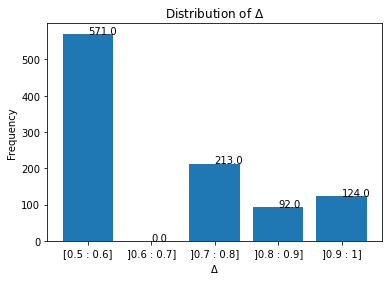

In [14]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

langs = ['[0.5 : 0.6]', ']0.6 : 0.7]', ']0.7 : 0.8]', ']0.8 : 0.9]', ']0.9 : 1]']

y_pos = np.arange(len(langs))

plt.title("Distribution of $\Delta$")
# Create bars
plt.bar(y_pos, delta_2)

addlabels(langs, delta_2 )
# Create names on the x-axis
plt.xticks(y_pos, langs)
plt.xlabel("$\Delta$")
plt.ylabel("Frequency")
#make label
label = [delta_2]
# Show graphic
plt.show()

In [15]:
samlet_prof = total_profit_plot.mean(0)
window_size = 1000
  
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
# Loop through the array t o
#consider every window of size 1000
while i < len(samlet_prof) - window_size + 1:
  
    # Calculate the average of current window
    window_average = np.sum(samlet_prof[i:i+window_size]) / window_size
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1

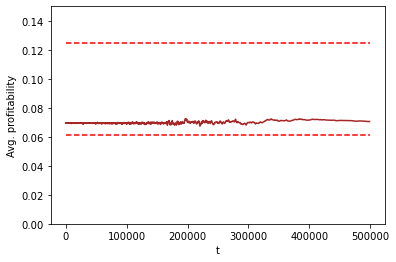

In [16]:
plt.plot(moving_averages, color='#a62626', label="Average profitability")
plt.xlabel('t')
plt.ylabel('Avg. profitability')
plt.ylim(0.00, 0.15)
plt.hlines(y=0.0611, xmin=0, xmax=500000, colors='red', linestyles='--')
plt.hlines(y=0.125, xmin=0, xmax=500000, colors='red', linestyles='--')
plt.show()